# Ejemplo: U-net para segmentación de imágenes aereas

## Problema: queremos determinar la etiqueta de píxeles individuales. De esta forma, podemos construir un clasificador para identificar partes de una imagen. Una aplicación de esta técnica es la segmentación de imágenes aereas:
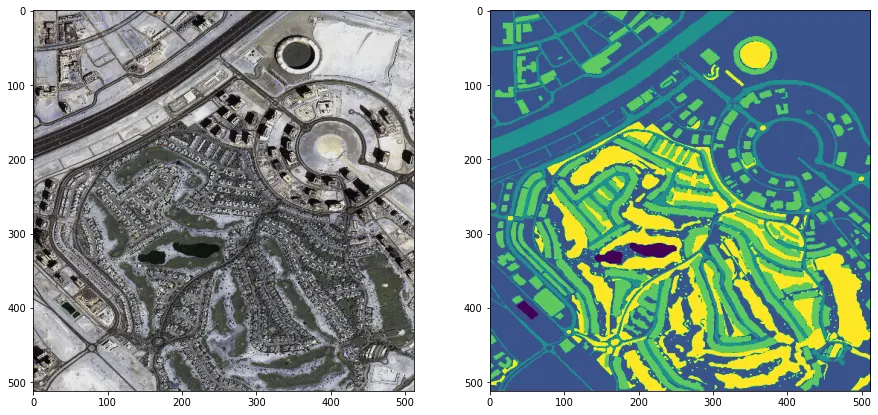

## Queremos hacer una red tipo U-net, donde hay una parte *encoding* que se encarga de identificar características de los inputs, y una parte de *decoding*, que se encarga de generar el output deseado: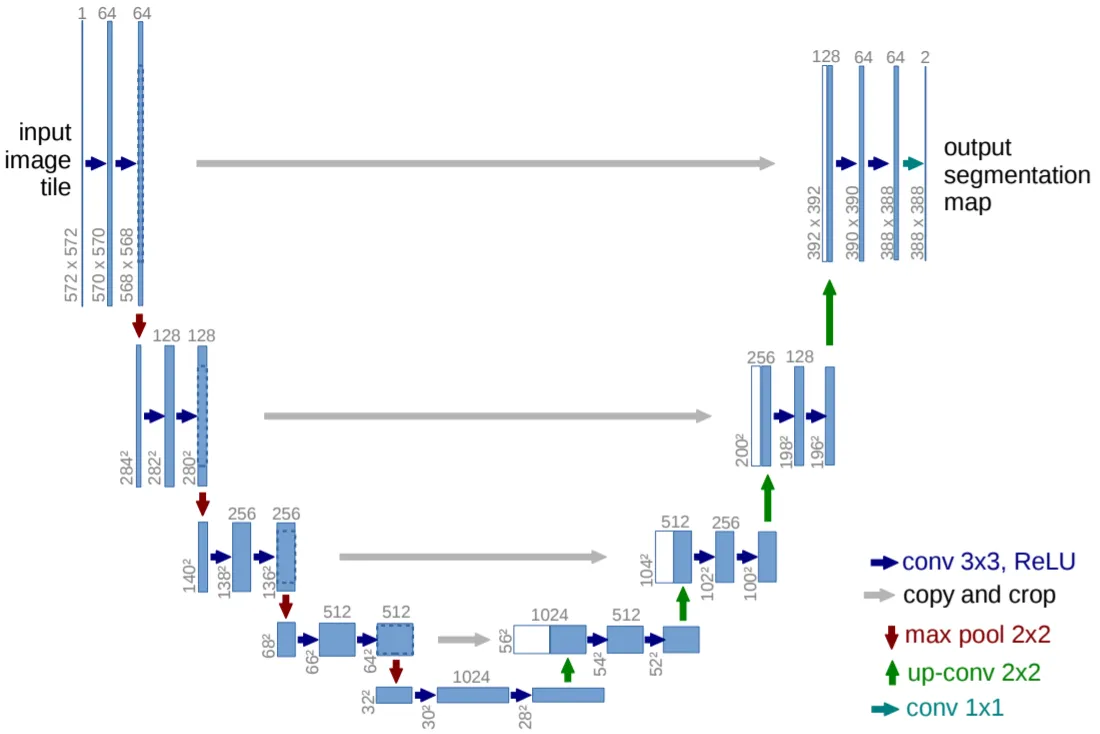

Importamos librerías:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#vamos a usar siempre una placa de video
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Definimos una clase que realiza dos convoluciones. Va a ser usada tanto en el downscaling como en el upscaling.

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

La clase ```Down``` aplica una operación de downscaling: divide el tamaño de la imagen en 2 y aplica una doble convolución.

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

La clase ```Up``` aplica una convolución transpuesta o una transformación bilineal unsample para duplicar la dimensión de la imagen. Luego, aplica una doble convolución.

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

la clase ```Unet``` es la red terminada. Aplica cuatro operaciones downsampling-doble convolución y cuatro operaciones upsampling-doble convolución:

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

descomprimo el dataset:

In [ ]:
import dataloader #archivo donde esta la herramienta para cargar los datos
import shutil
filename = "./seg_dataset.zip"
extract_dir = "./"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)

Defino algunos hiperparámetros: número de épocas, tamaño de los batchs, tasa de aprendizaje y la función de costo.

In [ ]:
from losses import FocalLoss, mIoULoss

N_EPOCHS = 100
BACH_SIZE = 2
learning_rate = 1e-3
loss_ = 'focalloss'

#inicializo la loss
if loss_ == 'focalloss':
    criterion = FocalLoss(gamma=3/4).to(device)
elif loss_ == 'crossentropy':
    criterion = nn.CrossEntropyLoss().to(device)
else:
    print('Loss function not found!')


## Este es un problema de datos muy desbalanceados, por lo que necesitamos pesar las etiquetas de alguna forma.

## Focal Loss

$$ -\alpha_c(1-\hat{y}_i)^\gamma\,log\hat{y}_i $$

Cuando tenemos un dataset desbalanceado, esta función de costo agrega un término para reducir el impacto de predicciones correctas, y se centra en las prediciones incorrectas. El factor $\gamma$ maneja la intensidad de esta reducción.

En nuestro problema de segmentación, es muy posible que una clase sea minoritaria (un camino en medio de un bosque por ejemplo), por lo que esta función de costo puede mejorar la efectividad de la red.


Inicializo los dos dataloaders (entrenamiento y validación).

Las imágenes requieren un preprocesado: se les aplica un *colorshift* y *blur*


In [ ]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = dataloader.segDataset('./Semantic segmentation dataset', training = True, transform= t)

print('Number of data : '+ str(len(dataset)))

#usamos el 10% de los datos para el dataset de testing
test_num = int(0.1 * len(dataset))

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(13)
    )

N_DATA, N_TEST = len(train_dataset), len(test_dataset)

#genero los dataloaders para ser iterados en el loop principal
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=1)


Number of data : 72


Defino una función para calcular la precisión obtenida por la red:

In [ ]:
def acc(label, predicted):
    seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
    return seg_acc

Inicializo la red. El optimizador que vamos a usar es Adam con una tasa de aprendizaje adaptativa.

In [ ]:
model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
min_loss = torch.tensor(float('inf'))

#achica la taza de aprendizaje en un factor gamma
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)


Loop principal: entrenamiento de la red

In [ ]:
import os
import sys
import matplotlib.pyplot as plt

os.makedirs('./saved_models', exist_ok=True)

plot_losses = []
scheduler_counter = 0

loss_val = []   #listas donde voy a guardar
loss_train = [] #las funciones de costo de cada época

acc_val = []
acc_train = []

for epoch in range(N_EPOCHS):

    # training
    model.train()
    loss_list = []
    acc_list = []
    for batch_i, (x, y) in enumerate(train_dataloader):
        #x es la imagen, y son las etiquetas de los pixels
        pred_mask = model(x.to(device))
        loss = criterion(pred_mask, y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.cpu().detach().numpy())
        acc_list.append(acc(y,pred_mask).numpy())

        #forma aesthetic de ver el progreso de la red
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
            % (
                epoch,
                N_EPOCHS,
                batch_i,
                len(train_dataloader),
                loss.cpu().detach().numpy(),
                np.mean(loss_list),
            )
        )
    scheduler_counter += 1

    # testing
    model.eval()
    val_loss_list = []
    val_acc_list = []
    for batch_i, (x, y) in enumerate(test_dataloader):
        with torch.no_grad():
            pred_mask = model(x.to(device))
        val_loss = criterion(pred_mask, y.to(device))
        val_loss_list.append(val_loss.cpu().detach().numpy())
        val_acc_list.append(acc(y,pred_mask).numpy())

    print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                np.mean(loss_list),
                                                                                                np.mean(acc_list),
                                                                                                np.mean(val_loss_list),
                                                                                                np.mean(val_acc_list)))

    loss_train.append(np.mean(loss_list))
    loss_val.append( np.mean(val_loss_list))

    acc_train.append( np.mean(acc_list))
    acc_val.append( np.mean(val_acc_list))


    compare_loss = np.mean(val_loss_list)
    is_best = compare_loss < min_loss
    if is_best == True:
        scheduler_counter = 0
        min_loss = min(compare_loss, min_loss)
        torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))

    if scheduler_counter > 5:
        lr_scheduler.step()
        print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
        scheduler_counter = 0



[Epoch 0/100] [Batch 32/33] [Loss: 0.524036 (1.006473)] epoch 0 - loss : 1.00647 - acc : 0.61 - val loss : 0.87854 - val acc : 0.69
[Epoch 1/100] [Batch 32/33] [Loss: 0.846549 (0.833494)] epoch 1 - loss : 0.83349 - acc : 0.65 - val loss : 0.74297 - val acc : 0.71
[Epoch 2/100] [Batch 32/33] [Loss: 1.041824 (0.809940)] epoch 2 - loss : 0.80994 - acc : 0.66 - val loss : 0.79890 - val acc : 0.67
[Epoch 3/100] [Batch 32/33] [Loss: 0.504171 (0.843523)] epoch 3 - loss : 0.84352 - acc : 0.65 - val loss : 0.76283 - val acc : 0.70
[Epoch 4/100] [Batch 32/33] [Loss: 0.708788 (0.811779)] epoch 4 - loss : 0.81178 - acc : 0.65 - val loss : 0.82273 - val acc : 0.48
[Epoch 5/100] [Batch 32/33] [Loss: 0.945551 (0.770018)] epoch 5 - loss : 0.77002 - acc : 0.67 - val loss : 0.67305 - val acc : 0.75
[Epoch 6/100] [Batch 32/33] [Loss: 1.934412 (0.719139)] epoch 6 - loss : 0.71914 - acc : 0.68 - val loss : 0.59474 - val acc : 0.75
[Epoch 7/100] [Batch 32/33] [Loss: 1.281771 (0.705127)] epoch 7 - loss : 0.7

Ploteamos la función de costo y la precisión de la red en función de las épocas:

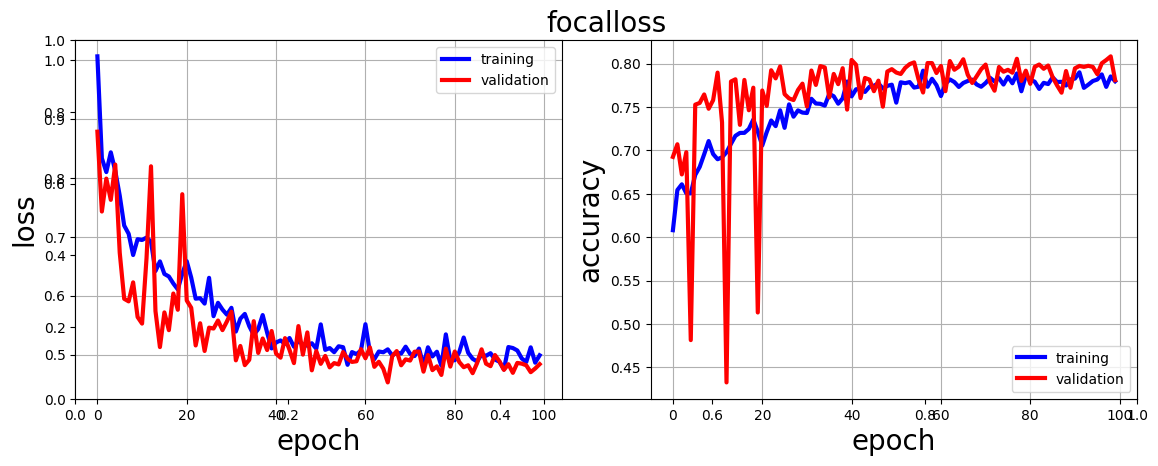

In [ ]:
# plot loss
fig = plt.figure(figsize=(12,5))
plt.title(loss_, fontsize=20)

ax1 = fig.add_subplot(121)
ax1.plot(loss_train, color='b', linewidth=3)
ax1.plot(loss_val, color='r', linewidth=3)
ax1.set_xlabel('epoch',fontsize=20)
ax1.set_ylabel('loss',fontsize=20)
ax1.grid()
ax1.legend(['training', 'validation']) # using a named size

ax2 = fig.add_subplot(122)
ax2.plot(acc_train, color='b', linewidth=3)
ax2.plot(acc_val, color='r', linewidth=3)
ax2.set_xlabel('epoch',fontsize=20)
ax2.set_ylabel('accuracy',fontsize=20)
ax2.grid()
ax2.legend(['training', 'validation']) # using a named size

fig.tight_layout()
plt.show()


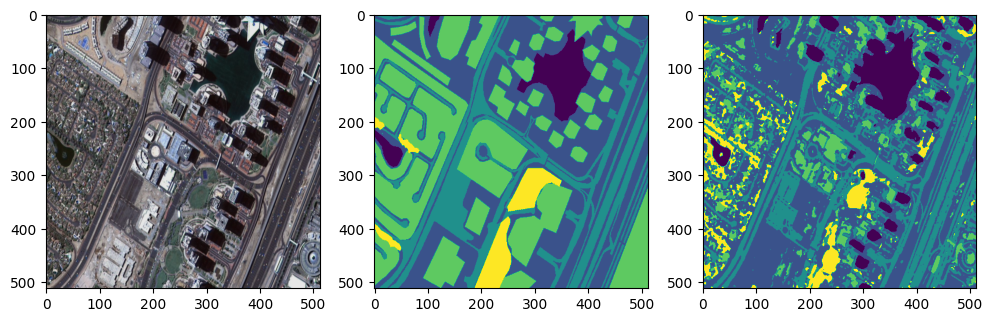

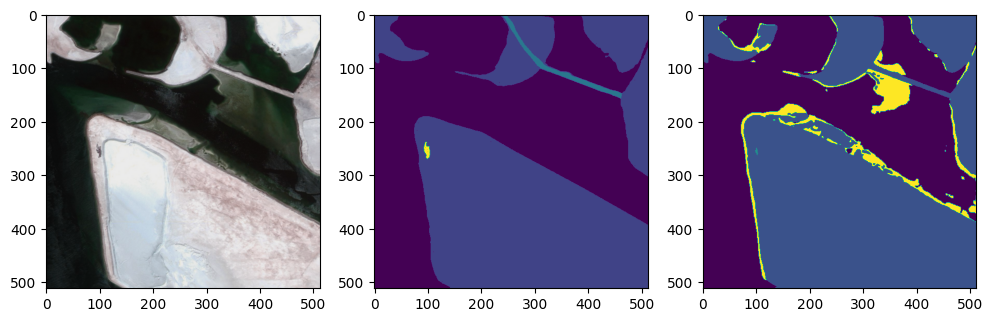

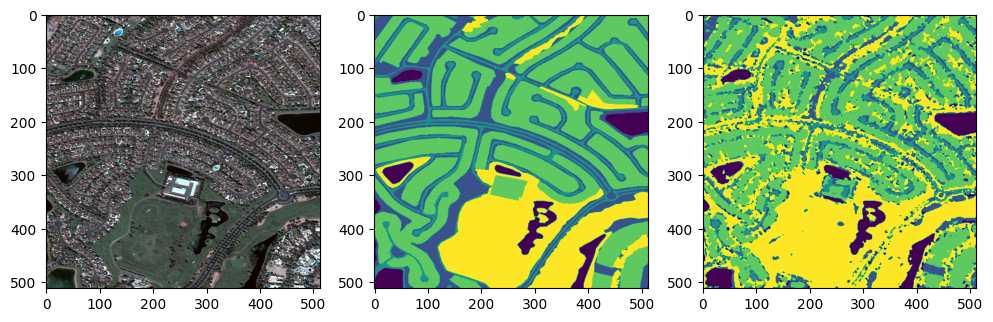

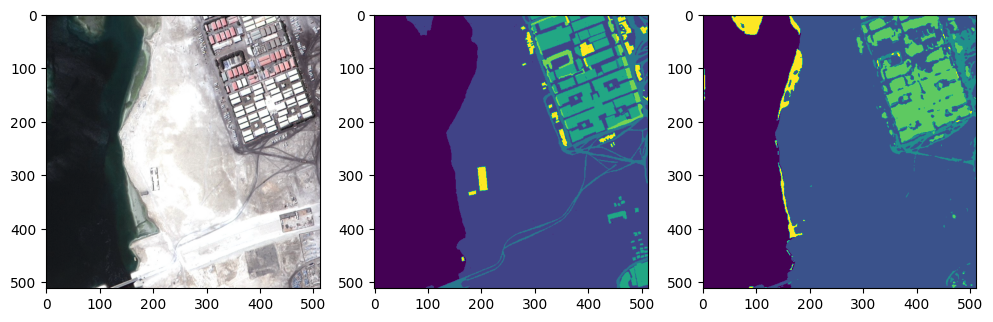

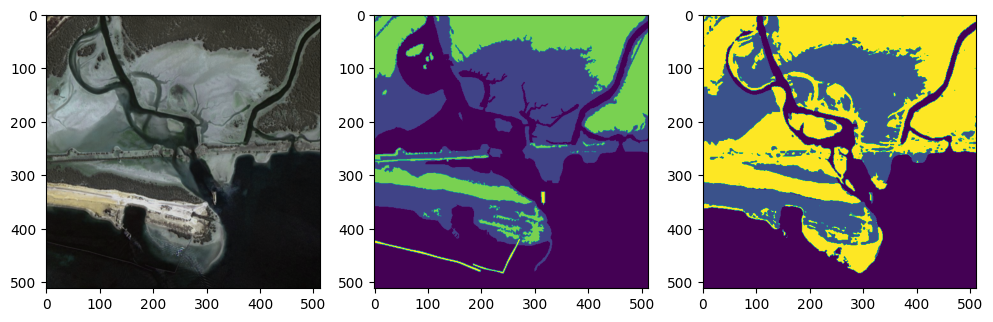

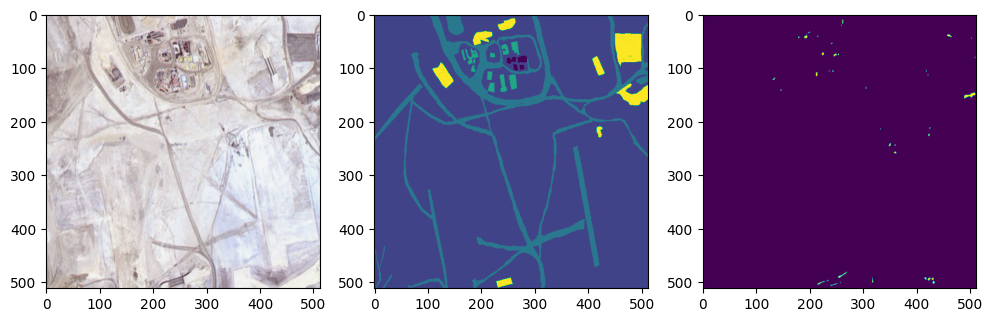

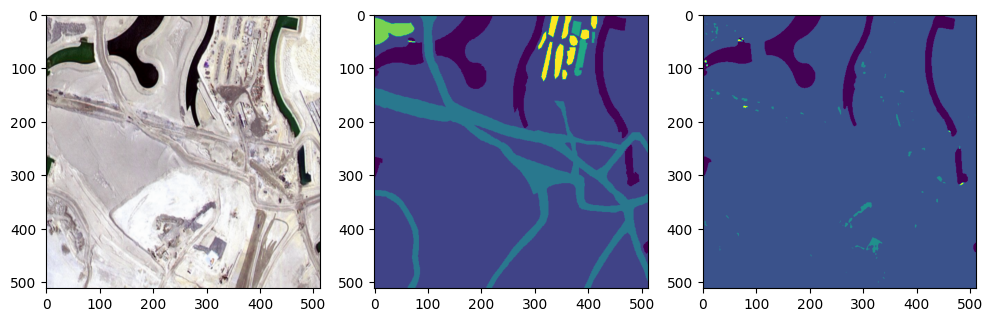

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))
        #print(np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy())
        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)

        plt.show()

# Ejercicio 1: Pruebe con otras funciones de costo y vea si nota diferencia en el entrenamiento.

---
# Ejercicio 2: Cambie la forma de hacer el upscaling a la convolución transpuesta y reentrene la red. Compare los resultados con el resultado de la transformación  bililneal.
---

# Ejercicio 3: La red mostrada en este cuaderno tiene *skip connections*. Cree una red idéntica a esta, pero sin esas conexiones y entrénela.

## Ayuda: las *skip connections* están definidas en los atributos de la clase `Up`, en su método `forward`. Por ejemplo, cuando se hace `x = self.up2(x, x3)` (que es un objeto de la clase `Up`), se hace el upscaling desde el estado anterior de `x`, y se le agrega el output proveniente del downscaling correspondiente.

## Lo que tiene que lograr es que el upscaling depeda sólo del estado anterior: `x = self.up2(x)`